In [27]:
# ============================================================
# Cell 1: Imports and basic config
# ============================================================

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import grad

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [28]:
# ============================================================
# Cell 2: Reproducibility helpers
# ============================================================

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


In [29]:
# ============================================================
# Cell 3: PINN model definition
# Input: (x, t) in R^2
# Output: u(x, t) in R
# ============================================================

class HeatPINN(nn.Module):
    def __init__(self, layers):
        """
        layers: list like [2, 64, 64, 64, 1]
        """
        super().__init__()
        net = []
        for i in range(len(layers) - 1):
            in_dim = layers[i]
            out_dim = layers[i + 1]
            linear = nn.Linear(in_dim, out_dim)
            # Xavier initialization
            nn.init.xavier_uniform_(linear.weight)
            nn.init.zeros_(linear.bias)
            net.append(linear)
            if i < len(layers) - 2:
                net.append(nn.Tanh())
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        """
        x: (N, 1)
        t: (N, 1)
        inp: (N, 2)
        returns u: (N, 1)
        """
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)


In [30]:
# ============================================================
# Cell 4: Sampling collocation, boundary, and initial points
# Domain: x in [0, 1], t in [0, 1]
# ============================================================

def sample_collocation_points(n_f: int):
    """Interior points for PDE residual."""
    x_f = torch.rand(n_f, 1)
    t_f = torch.rand(n_f, 1)
    return x_f.to(device), t_f.to(device)

def sample_initial_points(n_ic: int):
    """Points at t = 0 with u(x, 0) = sin(pi x)."""
    x_ic = torch.rand(n_ic, 1)
    t_ic = torch.zeros_like(x_ic)
    u_ic = torch.sin(math.pi * x_ic)
    return x_ic.to(device), t_ic.to(device), u_ic.to(device)

def sample_boundary_points(n_bc: int):
    """Points at x = 0 and x = 1, BC: u(0, t) = 0, u(1, t) = 0."""
    t_bc = torch.rand(n_bc, 1)
    x0 = torch.zeros_like(t_bc)
    x1 = torch.ones_like(t_bc)
    u0 = torch.zeros_like(t_bc)
    u1 = torch.zeros_like(t_bc)
    return (
        x0.to(device), t_bc.to(device), u0.to(device),
        x1.to(device), t_bc.to(device), u1.to(device)
    )


In [31]:
# ============================================================
# Cell 5: Autograd helpers to compute derivatives
# ============================================================

def gradients(y, x):
    """
    Compute dy/dx for scalar y and tensor x using autograd.
    y: (N, 1)
    x: (N, 1)
    returns: dy/dx with shape (N, 1)
    """
    return grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

def second_derivative(y, x):
    """
    Compute d2y/dx2 using autograd.
    """
    dy_dx = gradients(y, x)
    d2y_dx2 = gradients(dy_dx, x)
    return d2y_dx2


In [32]:
# ============================================================
# Cell 6: Physics-informed loss computation
# PDE: u_t = u_xx
# ============================================================

def pde_residual(model, x_f, t_f):
    """
    Compute the PDE residual r(x, t) = u_t - u_xx
    at the collocation points.
    """
    x_f.requires_grad = True
    t_f.requires_grad = True

    u_f = model(x_f, t_f)  # (N_f, 1)

    # First derivative wrt t
    u_t = gradients(u_f, t_f)

    # Second derivative wrt x
    u_xx = second_derivative(u_f, x_f)

    residual = u_t - u_xx
    return residual


In [33]:
# ============================================================
# Cell 7: Exact solution for comparison
# u(x, t) = exp(-pi^2 t) * sin(pi x)
# ============================================================

def exact_solution(x, t):
    """
    x, t are numpy arrays or tensors.
    Returns u(x, t) = exp(-pi^2 t) * sin(pi x)
    """
    return np.exp(- (math.pi ** 2) * t) * np.sin(math.pi * x)


In [35]:
# ============================================================
# Cell 8: Training loop
# ============================================================

# Hyperparameters
layers = [2, 64, 64, 64, 1]
num_epochs = 2000
n_f = 3000    # collocation points
n_ic = 200    # initial condition points
n_bc = 200    # boundary condition points
lr = 1e-3

model = HeatPINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()

loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Sample points
    x_f, t_f = sample_collocation_points(n_f)
    x_ic, t_ic, u_ic = sample_initial_points(n_ic)
    x0, t0, u0, x1, t1, u1 = sample_boundary_points(n_bc)

    # PDE loss
    r = pde_residual(model, x_f, t_f)
    loss_pde = mse_loss(r, torch.zeros_like(r))

    # Initial condition loss
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = mse_loss(u_ic_pred, u_ic)

    # Boundary condition loss
    u0_pred = model(x0, t0)
    u1_pred = model(x1, t1)
    loss_bc = mse_loss(u0_pred, u0) + mse_loss(u1_pred, u1)

    # Total loss
    loss = loss_pde + loss_ic + loss_bc

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch}/{num_epochs} "
            f"Loss: {loss.item():.4e}  "
            f"(PDE: {loss_pde.item():.4e}, "
            f"IC: {loss_ic.item():.4e}, "
            f"BC: {loss_bc.item():.4e})"
        )


Epoch 500/2000 Loss: 1.5011e-02  (PDE: 4.8254e-03, IC: 6.9714e-03, BC: 3.2144e-03)
Epoch 1000/2000 Loss: 3.9228e-03  (PDE: 2.2187e-03, IC: 8.2764e-04, BC: 8.7653e-04)
Epoch 1500/2000 Loss: 1.5375e-03  (PDE: 9.0902e-04, IC: 3.1104e-04, BC: 3.1746e-04)
Epoch 2000/2000 Loss: 9.2509e-04  (PDE: 5.1708e-04, IC: 1.5943e-04, BC: 2.4859e-04)


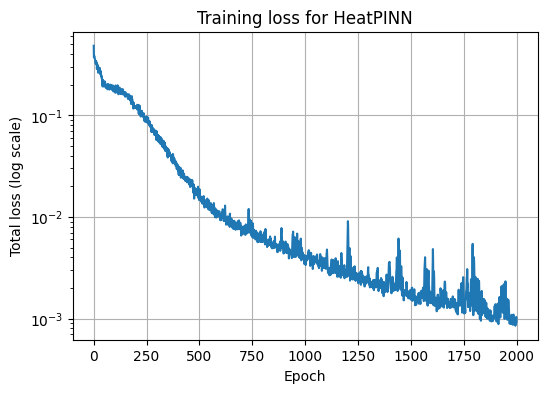

In [36]:
# ============================================================
# Cell 9: Plot training loss
# ============================================================

plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Total loss (log scale)")
plt.title("Training loss for HeatPINN")
plt.grid(True)
plt.show()


In [37]:
# ============================================================
# Cell 10: Evaluate the model on a grid
# ============================================================

model.eval()

# Create grid
nx, nt = 100, 100
x_vals = np.linspace(0.0, 1.0, nx)
t_vals = np.linspace(0.0, 1.0, nt)
X, T = np.meshgrid(x_vals, t_vals)

x_grid = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
t_grid = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(x_grid, t_grid).cpu().numpy().reshape(nt, nx)

u_exact = exact_solution(X, T)
error = np.abs(u_pred - u_exact)


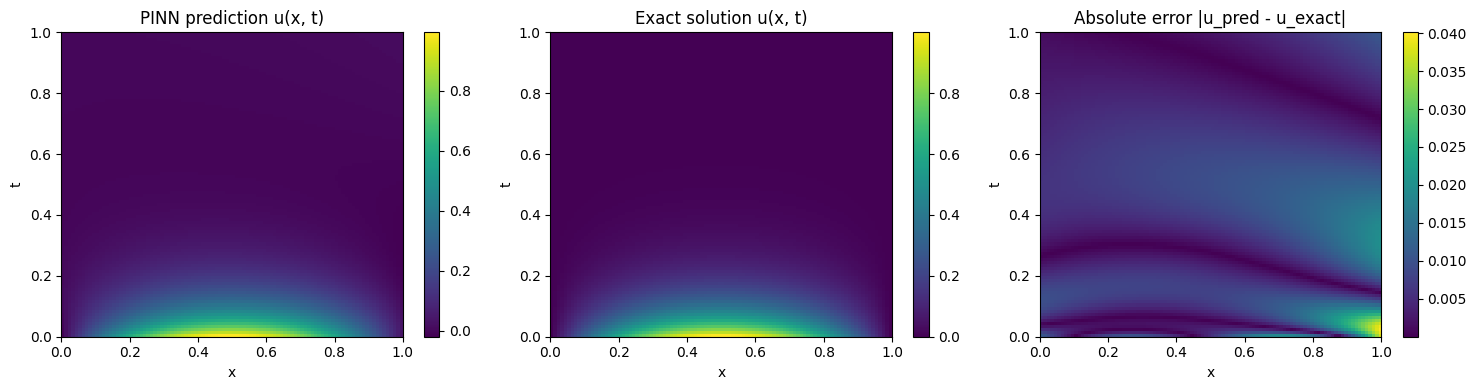

In [38]:
# ============================================================
# Cell 11: Plot predicted vs exact vs error
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(
    u_pred,
    extent=[0, 1, 0, 1],
    origin="lower",
    aspect="auto"
)
axes[0].set_title("PINN prediction u(x, t)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    u_exact,
    extent=[0, 1, 0, 1],
    origin="lower",
    aspect="auto"
)
axes[1].set_title("Exact solution u(x, t)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    error,
    extent=[0, 1, 0, 1],
    origin="lower",
    aspect="auto"
)
axes[2].set_title("Absolute error |u_pred - u_exact|")
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


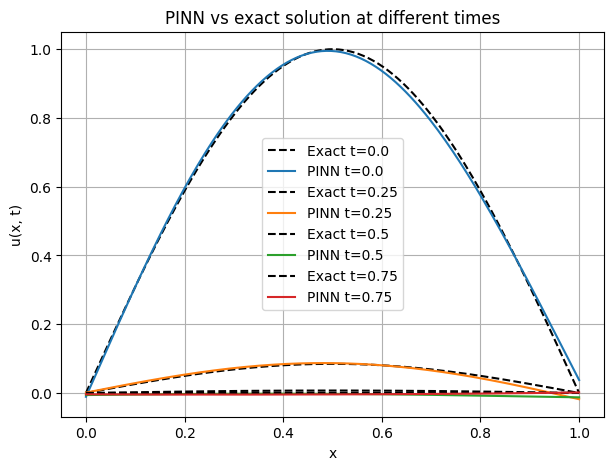

In [39]:
# ============================================================
# Cell 12 1D slice comparison at fixed times
# ============================================================

times_to_plot = [0.0, 0.25, 0.5, 0.75]

plt.figure(figsize=(7, 5))

for t0 in times_to_plot:
    x_test = np.linspace(0, 1, 200)
    x_torch = torch.tensor(x_test, dtype=torch.float32).view(-1, 1).to(device)
    t_torch = torch.full_like(x_torch, float(t0)).to(device)

    with torch.no_grad():
        u_slice_pred = model(x_torch, t_torch).cpu().numpy().flatten()

    u_slice_exact = exact_solution(x_test, t0)

    plt.plot(x_test, u_slice_exact, "k--", label=f"Exact t={t0}")
    plt.plot(x_test, u_slice_pred, label=f"PINN t={t0}")

plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title("PINN vs exact solution at different times")
plt.legend()
plt.grid(True)
plt.show()
